In [71]:
import math
import scipy
import scipy.io
import scipy.signal as s
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import statsmodels.api as sm
#from statsmodels.api import statsmodels.api.nonparametric.smoothers_lowess as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x):
    total = sum(x)
    peak = int(len(x)/2)
    for i in range(1,10000):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999
    
#   t90(x) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of seconds

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

f1=test['Data1']
#f1=f2

f1=np.transpose(f1) #puts data on it's side (easier to work with rows)
f1=f1[::-1]#reverses 
f1 = f1*(10**6) #convert to micro pascals
fs = 500

In [72]:
# I. High Pass Filter to remove streamer noise

#Applies 3 biquad filters with 11hz cutoff to remove streamer noise, parameters come from fdatool

sos=[[1,-2,1,1,-1.82570619168342,0.881881926844246],[1,-2,1,1,-1.65627993129105,0.707242535896459],[1,-2,1,1,-1.57205200320457,0.620422971870477]]
#b1, a = s.butter(4, 22/fs, 'high', analog=False)
fData = []
for row in f1:
    fData.append(s.sosfilt(sos,row))
    #fData.append(s.filtfilt(b1,a,row))
fData=np.asarray(fData)#recast as ndarray


In [73]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData # adjusted filtered data

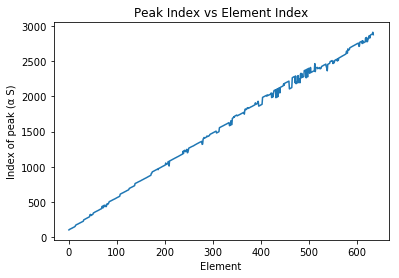

In [74]:
# III. Windowing Around Peak (2s before and after)
peak=[]

#forward 2 s
winData = []#windowed data
for row in fData:
    peak1 = np.argmax(row[0:10*fs])
    if(peak1>1000):#if the peak is 2s from the 0 index (window can be 4s)
        DATA = row[peak1-2*fs:peak1+2*fs]#Keep data around the peak (2s before and after)
    else:
        w = row[peak1:peak1+2*fs]#one-sided window
        DATA = np.concatenate((np.zeros(len(w)),w))#pad #check
    winData.append(DATA)
    peak.append(peak1)
winData = np.asarray(winData)#recast as ndarray
plt.plot(peak)
plt.title('Peak Index vs Element Index')
plt.xlabel('Element')
plt.ylabel('Index of peak (α S)')
plt.show()


[ 121.39415564  195.42322429  196.22974128  195.94797367  194.28623678
  194.35422832  194.19294967  196.07903553  197.05025848  196.95374037
  195.16983378  195.16976466  193.92280026  194.26605323  190.92031323
  191.7423375   192.86725361  193.35843811  193.34271823  193.21350482
  194.13749961  194.25815426  194.40266561  195.04360868  194.93565735
  194.83442546  194.41406527  194.50109095  195.05730404  193.97043049
  193.8152788   190.93732521  190.65880008  192.49267784  192.76248317
  193.09080005  192.01243014  192.4774954   191.3521034   191.95456401
  191.79785471  190.22414653  192.11383503  190.87665937  165.08516495
  186.80050074  170.9373665   135.95245997  189.30441573  188.42631257
  188.08290737  179.08903565  181.02186969  107.17825084  188.11587107
  188.48836782  188.02141518  187.63856587  189.63428308  190.53649119
  190.15330669  190.05397056  190.1391235   189.81528104  190.10490528
  190.31089996  190.55780403  190.44478258  193.08350292  181.50243881
  180.

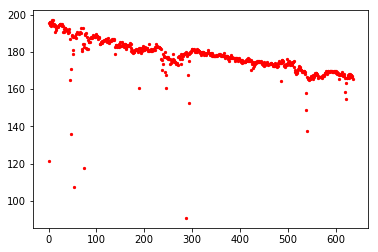

In [75]:
# IV. Calculate RMS of power

squaredPressure = np.multiply(winData,winData)

RMS = []
T90 = []
i = 0

for row in squaredPressure:
    T90a=t90(row)
    RMS.append(10*np.log10(sum(row)/(fs*T90a)))#integrate squared pressure / T90
    i = i+1
    T90.append(T90a)
RMS = np.asarray(RMS)#recast as ndarray
print(RMS)
print(T90)
b = np.linspace(0,len(RMS),len(RMS))
plt.scatter(b,RMS,s=5,c='r')
plt.show()

In [76]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for rms in RMS:
    SEL.append(rms+10*np.log10(T90[i]))# RMS + log(T90)
    i = i+1
SEL = np.asarray(SEL)#recast as ndarray
print(SEL)

#scipy.io.savemat('Data1.mat', mdict={'SEL':SEL,'RMS':RMS,'Windowed': winData,'Filtered':fData,'Original':f1})#debug

[ 116.10707275  187.87835097  187.8133662   187.9891735   187.63077429
  187.8567085   187.61717648  189.42357305  187.84207094  187.59832026
  187.10107976  187.31820314  186.47552531  186.41449171  183.17340604
  183.44495465  183.93935331  184.15025057  184.27693508  184.00531728
  184.7820795   185.04996672  185.19447807  185.83542114  185.72746981
  185.62623792  185.20587773  185.29290341  185.54948427  184.61501038
  184.30745902  181.72913767  181.45061254  183.13725773  183.2546634
  183.4250376   182.65701003  183.26930786  182.28632025  183.2899531
  183.13324379  181.68542688  183.44922411  182.21204845  157.01641093
  177.87260043  161.58194639  141.2825502   179.30441573  178.42631257
  178.08290737  170.0232525   171.95608654  103.84343064  178.76045096
  179.13294772  178.66599508  178.1307461   180.27886298  181.32830365
  180.94511915  180.98818741  180.93093596  180.45986093  180.74948517
  181.10271242  181.3496165   181.23659504  183.72808281  174.42499952
  173.33

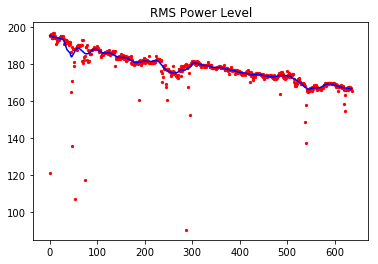

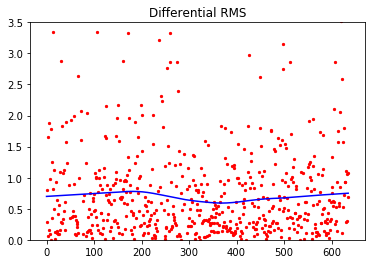

71 channels have been thrown out 
inaccurate: [0, 14, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 53, 67, 68, 69, 70, 71, 73, 75, 76, 77, 78, 79, 80, 82, 138, 188, 209, 235, 236, 237, 238, 244, 245, 246, 260, 276, 286, 287, 291, 294, 422, 484, 516, 517, 518, 537, 538, 539, 619, 620, 621] 
noisy: [0, 43, 44, 45, 46, 47, 50, 52, 53, 68, 70, 71, 74, 75, 78, 137, 187, 188, 243, 246, 286, 287, 290, 291, 293, 294, 483, 484, 536, 537, 538, 539, 620, 635]


In [92]:
#V. Remove noisy or inaccurate channels
RMS2=RMS.tolist()
SEL2=SEL.tolist()
RMS_diff=[]
inaccurate=[]
noisy=[]
indexes=[]

N=3
RMS_avg = np.convolve(RMS, np.ones((N,))/N, mode='valid')#rolling average of RMS
RMS_avg = np.concatenate((RMS_avg,RMS[len(RMS_avg):len(RMS_avg)+N-1]))#pad RMS_avg

for i in range(0,len(RMS)-1):
    RMS_diff.append(np.abs(RMS[i]-RMS[i+1]))#differential RMS
#RMS_diff.insert(0,999)#remove first index from consideration and shift the index back
RMS_diff.append(999)
RMS_diff_avg = np.convolve(RMS_diff, np.ones((N,))/N, mode='valid')#rolling average of differential RMS
RMS_diff_avg = np.concatenate((RMS_diff_avg,RMS[len(RMS_diff_avg):len(RMS_diff_avg)+N-1]))#pad

#RMS_avg=RMS###
#RMS_diff_avg=RMS_diff

b = np.linspace(0,len(RMS),len(RMS))
RMSlowess = sm.nonparametric.lowess(RMS_avg,b,0.05,return_sorted=False)#lowess using 5%
difflowess = sm.nonparametric.lowess(RMS_diff_avg,b,0.5,return_sorted=False)

plt.plot(RMSlowess,c='b')
plt.scatter(b,RMS,s=5,c='r')
plt.title('RMS Power Level')
plt.show()

for i in range(0,len(RMS)):
    if(np.abs(RMSlowess[i]-RMS[i])>3):#inacurate should be 2
        inaccurate.append(i)
    if(np.abs(difflowess[i]-RMS_diff[i])>7):#noisy should be 0.5
        noisy.append(i)        
indexes = np.sort(list(set(np.concatenate((inaccurate,noisy)))))#consolidate
#print(indexes)
for index in sorted(indexes, reverse=True):#remove bad channels
    del RMS2[int(index)]#reversed so that removing doesn't effect the following indexes
    del SEL2[int(index)]
    #del RMS_diff[int(index)]

#plt.plot(RMS2)
#plt.scatter(b,RMS2,s=5)
#plt.scatter(b,SEL2,s=5)
plt.plot(difflowess,c='b')
plt.scatter(b,RMS_diff,s=5,c='r')
plt.ylim([0,3.5])
plt.title('Differential RMS')
plt.show()
print(len(indexes),'channels have been thrown out','\ninaccurate:',inaccurate,'\nnoisy:',noisy)


SEL180 = 0.8
SEL160 = 7.0625
RMS180 = 3.4625000000000004
RMS160 = 7.0625


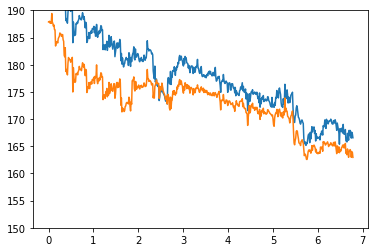

In [93]:
#VI. Fitting Data

b = np.linspace(0,len(RMS2),len(RMS2))
SELpol = scipy.interpolate.interp1d(b,SEL2,kind='linear',bounds_error=False,fill_value=True) 
RMSpol = scipy.interpolate.interp1d(b,RMS2,kind='linear',bounds_error=False,fill_value=True)

SEL180 = -1
SEL160 = -1
RMS180 = -1
RMS160 = -1

for i in range(0,1000):
    if(SELpol(i)>180):
        SEL180 = i
    if(SELpol(i)>160):
        SEL160 = i
    if(RMSpol(i)>180):
        RMS180 = i
    if(RMSpol(i)>160):
        RMS160 = i
SEL180 = SEL180*(12.5/1000)#converts from index to length in km
SEL160 = SEL160*(12.5/1000)
RMS180 = RMS180*(12.5/1000)
RMS160 = RMS160*(12.5/1000)

print('SEL180 =',SEL180)#Safety radii
print('SEL160 =',SEL160)
print('RMS180 =',RMS180)
print('RMS160 =',RMS160)

plt.plot(b*12/1000,RMSpol(b))
plt.plot(b*12/1000,SELpol(b))
plt.ylim([150,190])
plt.show()

In [79]:
#Calculate Differential RMS
#winData is windowed data
#RMS.append(10*np.log10(sum(row)/(fs*T90a)))#integrate squared pressure / T90
diffRMS=[]
prevrow=winData[0]
for row in winData:
    d=np.abs(prevrow-row)
    diffRMS.append(10*np.log10(sum(d**2)/(T90[i]*fs)))
    prevrow=row

plt.plot(diffRMS)
plt.show()

IndexError: list index out of range